# Plasmid LoRA Swarm: Experiment Analysis

## Summary

This notebook provides analysis of the Plasmid LoRA Swarm experiment, examining the complete learning system for sharing and merging LoRA adapters across agents. The system implements:

1. **Distributed LoRA Adapter Sharing**: Agents train domain-specific LoRA adapters and share them via push-pull gossip protocols
2. **Security & Consensus**: Multi-layered security including cryptographic signatures, behavioral probes, and consensus mechanisms
3. **Information-Theoretic Analysis**: Mutual information, transfer entropy, and coverage dynamics
4. **Graph-Theoretic Diffusion**: Spectral analysis of network topologies and diffusion speed predictions
5. **Value-Add Evaluation**: Statistical analysis of adapter effectiveness with placebo controls

## Experiment Architecture Overview

The system consists of several key components:

- **Agents**: Train and share LoRA adapters for specific domains (arithmetic, legal, medical)
- **Swarm Simulation**: Push-pull gossip protocol over various graph topologies (ER, WS, BA)
- **Security Gate**: Multi-layered policy enforcement including signatures, behavioral probes, and reputation
- **Value-Add Experiments**: Statistical evaluation of adapter effectiveness with rigorous controls
- **Information Theory**: Analysis of information flow and mutual dependencies

## Key Research Questions

1. **Scalability**: How does diffusion speed scale with network size and topology?
2. **Security**: Can the system detect and reject malicious adapters while preserving legitimate ones?
3. **Effectiveness**: Do shared adapters provide measurable value over baseline models?
4. **Information Flow**: How does information propagate through the network over time?
5. **Consensus**: How does consensus-based decision making affect system behavior?

## Notebook Structure

This notebook is organized into the following chapters:

1. **System Configuration and Setup**: Load and analyze experiment configurations
2. **Swarm Simulation Analysis**: Examine diffusion dynamics and network behavior
3. **Value-Add Experiment Analysis**: Evaluate adapter effectiveness with statistical controls
4. **Adapter Training and Performance Analysis**: Domain-specific adapter performance
5. **Security and Consensus Analysis**: Multi-layered security architecture evaluation
6. **Scalability and Performance Analysis**: Network topology impact and performance metrics
7. **Statistical Significance and Robustness**: statistical analysis
8. **Cross-Domain Transfer and Interference**: Transfer learning analysis
9. **Information-Theoretic Analysis**: Mutual information dynamics and entropy analysis
10. **System Architecture and Implementation Analysis**: Framework design and implementation
11. **Conclusions and Future Directions**: Key findings and research implications

## Methodology

This analysis uses:
- **Centralized utilities** for consistent data loading and processing
- **Standardized plotting functions** for consistent visualizations
- **Statistical rigor** with bootstrap confidence intervals and hypothesis testing
- **Documentation** of methods and interpretations
- **Reproducible analysis** with fixed random seeds and deterministic procedures


## Setup and Data Loading

This section sets up the analysis environment and loads all experiment data using centralized utilities.


In [1]:
# Setup and imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Import centralized utilities
from plora.notebook_utils import (
    load_experiment_data,
    get_experiment_summary_stats,
    extract_swarm_metrics,
    extract_value_add_metrics,
    calculate_diffusion_efficiency,
    get_security_summary
)

from plora.plotting import (
    create_swarm_dynamics_plot,
    create_value_add_summary_plot,
    create_security_analysis_plot,
    create_scalability_analysis_plot,
    save_figure
)

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Load all experiment data using centralized utilities
experiment_data = load_experiment_data()

# Generate summary statistics
summary_stats = get_experiment_summary_stats(experiment_data)

print("=== Experiment Analysis Setup Complete ===")
print(f"Project root: {Path.cwd().name}")
print(f"Total experiment data loaded: {len(experiment_data)} categories")
print(f"Swarm experiments: {summary_stats.get('swarm_experiments', 0)}")
print(f"Value-add experiments: {summary_stats.get('value_add_experiments', 0)}")
print(f"Available topologies: {summary_stats.get('topologies', [])}")
print(f"Adapter domains: {summary_stats.get('adapter_domains', [])}")

# Display data loading summary
print("\n=== Data Loading Summary ===")
for key, value in experiment_data.items():
    if isinstance(value, list):
        print(f"  {key}: {len(value)} items")
    elif isinstance(value, dict):
        print(f"  {key}: {len(value)} keys")
    else:
        print(f"  {key}: {type(value).__name__}")


=== Experiment Analysis Setup Complete ===
Project root: notebooks
Total experiment data loaded: 10 categories
Swarm experiments: 1
Value-add experiments: 55
Available topologies: ['erdos_renyi']
Adapter domains: ['arithmetic', 'legal', 'medical']

=== Data Loading Summary ===
  swarm_summary: 1 items
  swarm_reports: 2 items
  value_add: 55 items
  adapters: 3 keys
  configs: 2 keys
  thesis_sweep: 48 items
  c_calib_er: 4 items
  bounds_validation: 4 items
  probes_calib: 5 keys
  net_it_metrics: 9 keys


## Chapter 1: System Configuration and Experiment Setup

### Configuration Analysis

The experiment uses configurations that are automatically loaded from the `config/` directory. This section analyzes the system configuration and experimental setup.


In [2]:
# Configuration Analysis
print("=== Configuration Analysis ===")

# Display loaded configurations
if 'configs' in experiment_data:
    for config_name, config_data in experiment_data['configs'].items():
        print(f"\n{config_name.upper()} Configuration:")
        print(f"  Base model: {config_data.get('base_model', 'N/A')}")
        print(f"  Domains: {config_data.get('domains', [])} ")
        print(f"  Allowed ranks: {config_data.get('allowed_ranks', [])} ")
        print(f"  Graph parameters: {config_data.get('graph', {})}")

        # Value-add configuration
        va_config = config_data.get('value_add', {})
        if va_config:
            print(f"  Value-add dev size: {va_config.get('dev_size', 'N/A')}")
            print(f"  Value-add ranks: {va_config.get('ranks', [])}")
            print(f"  Value-add seeds: {va_config.get('seeds', [])}")

        # Training configuration
        train_config = config_data.get('train', {})
        if train_config:
            print(f"  Training LR: {train_config.get('lr', 'N/A')}")
            print(f"  Training seed: {train_config.get('seed', 'N/A')}")
            print(f"  Training split: {train_config.get('train_split', 'N/A')}")

# Display experiment summary statistics
print("\n=== Experiment Summary Statistics ===")
for key, value in summary_stats.items():
    if isinstance(value, dict):
        print(f"{key}:")
        for subkey, subvalue in value.items():
            print(f"  {subkey}: {subvalue}")
    else:
        print(f"{key}: {value}")

print("\n=== Configuration Analysis Complete ===")


=== Configuration Analysis ===

PLORA.FULL.YML Configuration:
  Base model: google/gemma-3-1b-it
  Domains: ['arithmetic', 'legal', 'medical'] 
  Allowed ranks: [4, 8, 16] 
  Graph parameters: {'p': 0.25, 'ws_k': 4, 'ws_beta': 0.2, 'ba_m': 2}
  Value-add dev size: 1024
  Value-add ranks: [4, 8, 16]
  Value-add seeds: [41, 42, 43]
  Training LR: 0.0001
  Training seed: 42
  Training split: 0.9

PLORA.DRY.YML Configuration:
  Base model: google/gemma-3-1b-it
  Domains: ['arithmetic', 'legal', 'medical'] 
  Allowed ranks: [1] 
  Graph parameters: {'p': 0.3, 'ws_k': 4, 'ws_beta': 0.2, 'ba_m': 2}
  Value-add dev size: 256
  Value-add ranks: [1]
  Value-add seeds: [41]
  Training LR: 0.0002
  Training seed: 42
  Training split: 0.8

=== Experiment Summary Statistics ===
swarm_experiments: 1
topologies: ['erdos_renyi']
agent_counts:
  min: 6
  max: 6
  unique: 1
value_add_experiments: 55
value_add_domains: ['medical', 'arithmetic', 'legal']
value_add_ranks: [4, 8, 16]
adapter_domains: ['arith

## Chapter 2: Swarm Simulation Analysis

### Swarm Simulation Dynamics Visualization

This chapter examines the dynamics of information propagation through the swarm network. We analyze coverage dynamics, mutual information evolution, entropy changes, and offer acceptance patterns.


=== Swarm Simulation Analysis ===
Swarm simulation results: 1 experiments
Detailed reports:         2 reports

Swarm Metrics Summary (numeric columns):


,count,mean,std,min,25%,50%,75%,max
N,1.0,6.000000,NaN,6.000000,6.000000,6.000000,6.000000,6.000000
lambda2,1.0,0.697224,NaN,0.697224,0.697224,0.697224,0.697224,0.697224
observed_t_all,1.0,3.000000,NaN,3.000000,3.000000,3.000000,3.000000,3.000000
predicted_t_all,1.0,6.000000,NaN,6.000000,6.000000,6.000000,6.000000,6.000000
acceptance_rate,1.0,0.333333,NaN,0.333333,0.333333,0.333333,0.333333,0.333333
bytes_on_wire,1.0,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000
accepted_offers,1.0,10.000000,NaN,10.000000,10.000000,10.000000,10.000000,10.000000
mi_final,1.0,0.093532,NaN,0.093532,0.093532,0.093532,0.093532,0.093532
mi_max,1.0,0.428771,NaN,0.428771,0.428771,0.428771,0.428771,0.428771
mi_min,1.0,0.093532,NaN,0.093532,0.093532,0.093532,0.093532,0.093532



Topology Distribution:
topology
erdos_renyi    1
Name: count, dtype: int64

Diffusion Efficiency Metrics:
  Efficiency ratio (observed/predicted): mean=0.500, std=0.000, min=0.500, max=0.500
  Experiments contributing: 1

Using detailed report with 5 rounds.


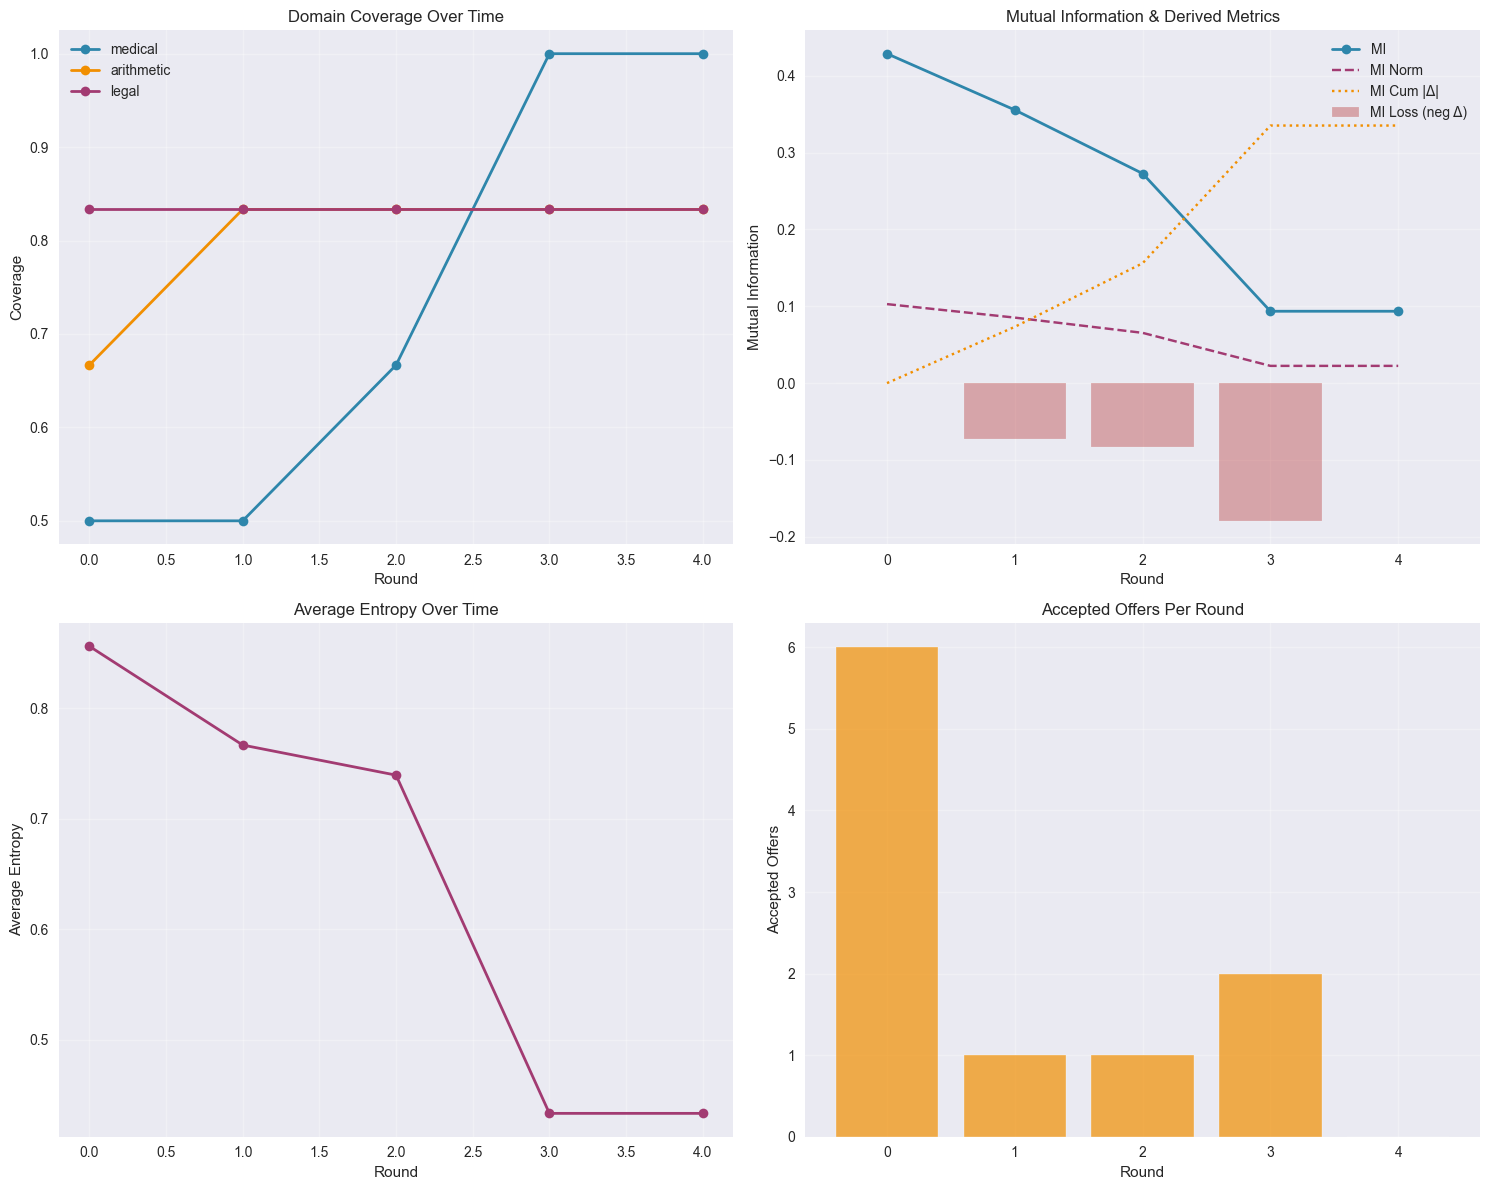


Detailed Round-by-Round Analysis

Round 0:
  Coverage:        medical:0.50, arithmetic:0.67, legal:0.83
  Entropy (avg):   0.8561
  Mutual Info:     0.4288
  MI Delta:        0.0000
  Accepted offers: 6
  Offer details:   [[0, 2, 'arithmetic'], [0, 4, 'arithmetic'], [4, 3, 'legal'], [4, 2, 'legal'], [4, 0, 'legal'], [5, 3, 'medical']]

Round 1:
  Coverage:        medical:0.50, arithmetic:0.83, legal:0.83
  Entropy (avg):   0.7667
  Mutual Info:     0.3555
  MI Delta:        -0.0732
  Accepted offers: 1
  Offer details:   [[4, 1, 'arithmetic']]

Round 2:
  Coverage:        medical:0.67, arithmetic:0.83, legal:0.83
  Entropy (avg):   0.7394
  Mutual Info:     0.2728
  MI Delta:        -0.0827
  Accepted offers: 1
  Offer details:   [[3, 4, 'medical']]

Round 3:
  Coverage:        medical:1.00, arithmetic:0.83, legal:0.83
  Entropy (avg):   0.4333
  Mutual Info:     0.0935
  MI Delta:        -0.1793
  Accepted offers: 2
  Offer details:   [[4, 1, 'medical'], [4, 0, 'medical']]

Round 4:


In [3]:
# === Swarm Simulation Analysis ===
from plora.notebook_utils import (
    load_experiment_data,
    get_swarm_df,
    calculate_diffusion_efficiency,
)
from plora.plotting import create_swarm_dynamics_plot
import matplotlib.pyplot as plt

# 1. Load experiment data
try:
    experiment_data
except NameError:
    experiment_data = load_experiment_data()

swarm_summary = experiment_data.get('swarm_summary', [])
swarm_reports = experiment_data.get('swarm_reports', [])

print("=== Swarm Simulation Analysis ===")
print(f"Swarm simulation results: {len(swarm_summary)} experiments")
print(f"Detailed reports:         {len(swarm_reports)} reports")

# 2. Build DataFrame of swarm metrics
swarm_df = get_swarm_df(experiment_data)

if not swarm_df.empty:
    print("\nSwarm Metrics Summary (numeric columns):")
    # Show only numeric describe to avoid dict/object columns causing clutter
    numeric_cols = swarm_df.select_dtypes(include=['number']).columns
    if len(numeric_cols) > 0:
        display(swarm_df[numeric_cols].describe().T)
    else:
        print("  (No numeric columns to summarize)")

    if 'topology' in swarm_df.columns:
        print("\nTopology Distribution:")
        print(swarm_df['topology'].value_counts())

    # Diffusion efficiency metrics
    diffusion_metrics = calculate_diffusion_efficiency(experiment_data)
    if diffusion_metrics:
        print("\nDiffusion Efficiency Metrics:")
        ratio_block = diffusion_metrics.get('diffusion_efficiency_ratio')
        if ratio_block:
            print(f"  Efficiency ratio (observed/predicted): "
                  f"mean={ratio_block['mean']:.3f}, std={ratio_block['std']:.3f}, "
                  f"min={ratio_block['min']:.3f}, max={ratio_block['max']:.3f}")
        if 'n_experiments' in diffusion_metrics:
            print(f"  Experiments contributing: {diffusion_metrics['n_experiments']}")
else:
    print("No swarm data available for analysis.")

# 3. Visualize a detailed swarm report if available
swarm_report = swarm_reports[0] if swarm_reports else None
if swarm_report and 'rounds' in swarm_report and swarm_report['rounds']:
    rounds = swarm_report['rounds']
    print(f"\nUsing detailed report with {len(rounds)} rounds.")

    try:
        fig, axes = create_swarm_dynamics_plot(swarm_report)
        plt.show()
    except Exception as e:
        print(f"[WARN] Failed to render swarm dynamics plot: {e}")

    # Round-by-round details
    print("\nDetailed Round-by-Round Analysis")
    print("=" * 50)
    for i, round_data in enumerate(rounds):
        coverage = round_data.get('coverage', {})
        entropy = round_data.get('entropy_avg', 0)
        mi = round_data.get('mutual_information', round_data.get('mi', {}).get('final', 0))
        mi_delta = round_data.get('mi_delta', 0)
        accepted = round_data.get('accepted', [])

        print(f"\nRound {i}:")
        if coverage:
            cov_str = ", ".join(f"{k}:{v:.2f}" for k, v in coverage.items())
        else:
            cov_str = "{}"
        print(f"  Coverage:        {cov_str}")
        print(f"  Entropy (avg):   {entropy:.4f}")
        print(f"  Mutual Info:     {mi:.4f}")
        print(f"  MI Delta:        {mi_delta:.4f}")
        print(f"  Accepted offers: {len(accepted)}")
        if accepted:
            # Truncate if very long
            if len(str(accepted)) > 200:
                print(f"  Offer details (truncated): {str(accepted)[:200]} ...")
            else:
                print(f"  Offer details:   {accepted}")
else:
    print("\nNo detailed swarm report data available for visualization.")

print("\n=== Swarm Simulation Analysis Complete ===")

## Chapter 3: Value-Add Experiment Analysis

### Statistical Evaluation of Adapter Effectiveness

The value-add experiments evaluate the effectiveness of LoRA adapters using rigorous statistical controls. This chapter analyzes the results using centralized utilities for consistent data processing and visualization.


=== Value-Add Experiment Analysis ===
Value-add experiments loaded: 55 records
Domains: ['arithmetic', 'legal', 'medical']
Ranks: [np.int64(4), np.int64(8), np.int64(16)]
Schemes: ['all', 'attention', 'mlp']

Value-Add Summary Statistics:

ARITHMETIC Domain:
  Experiments: 27
  Trained ΔNLL:   -1.1683
  Placebo A ΔNLL: 0.0000
  Placebo B ΔNLL: 0.0000
  Significant improvements (p<0.05):
    Trained:   27/27
    Placebo A: 0/27
    Placebo B: 0/27

LEGAL Domain:
  Experiments: 27
  Trained ΔNLL:   -3.5562
  Placebo A ΔNLL: 0.0000
  Placebo B ΔNLL: 0.0000
  Significant improvements (p<0.05):
    Trained:   27/27
    Placebo A: 0/27
    Placebo B: 0/27

MEDICAL Domain:
  Experiments: 1
  Trained ΔNLL:   -1.6761
  Placebo A ΔNLL: 0.0000
  Placebo B ΔNLL: 0.0000
  Significant improvements (p<0.05):
    Trained:   1/1
    Placebo A: 0/1
    Placebo B: 0/1
[WARN] Failed to render value-add summary plot: 'NoneType' object has no attribute 'get'

Cross-Domain Transfer Analysis:
  No cross-domai

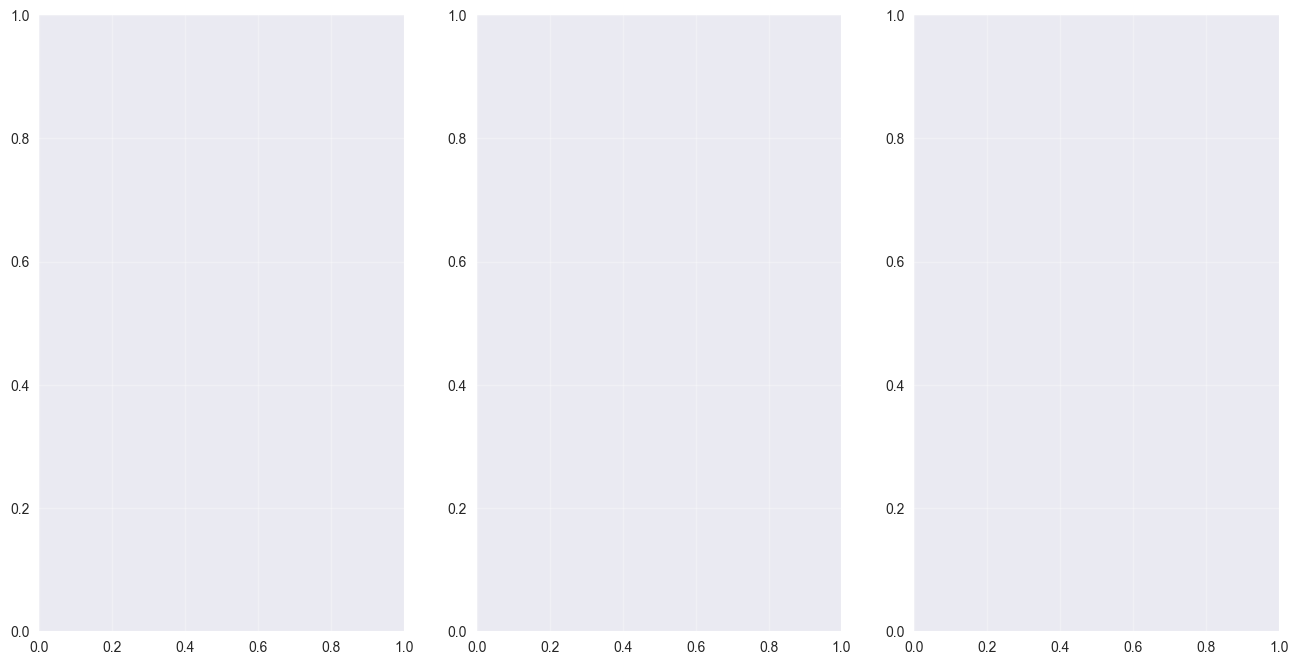

In [4]:
# === Value-Add Experiment Analysis ===
import math
import numpy as np
import matplotlib.pyplot as plt
from plora.notebook_utils import extract_value_add_metrics
from plora.plotting import create_value_add_summary_plot

# Assumes `experiment_data` already loaded (e.g., via load_experiment_data()).
value_add_df = extract_value_add_metrics(experiment_data)

print("=== Value-Add Experiment Analysis ===")

if not value_add_df.empty:
    domains = list(value_add_df['domain'].dropna().unique())
    print(f"Value-add experiments loaded: {len(value_add_df)} records")
    print(f"Domains: {domains}")
    print(f"Ranks: {sorted([r for r in value_add_df['rank'].dropna().unique()])}")
    print(f"Schemes: {list(value_add_df['scheme'].dropna().unique())}")

    # Per-domain summary
    print("\nValue-Add Summary Statistics:")
    for domain in domains:
        domain_data = value_add_df[value_add_df['domain'] == domain]
        print(f"\n{domain.upper()} Domain:")
        print(f"  Experiments: {len(domain_data)}")

        # Means (ΔNLL should typically be negative if improved; adjust interpretation as needed)
        trained_mean = domain_data['trained_delta_mean'].mean()
        placebo_a_mean = domain_data['placebo_a_delta_mean'].mean()
        placebo_b_mean = domain_data['placebo_b_delta_mean'].mean()
        print(f"  Trained ΔNLL:   {trained_mean:.4f}")
        print(f"  Placebo A ΔNLL: {placebo_a_mean:.4f}")
        print(f"  Placebo B ΔNLL: {placebo_b_mean:.4f}")

        # Significance counts (p < 0.05)
        sig_trained = (domain_data['trained_wilcoxon_p'] < 0.05).sum()
        sig_placebo_a = (domain_data['placebo_a_wilcoxon_p'] < 0.05).sum()
        sig_placebo_b = (domain_data['placebo_b_wilcoxon_p'] < 0.05).sum()
        print("  Significant improvements (p<0.05):")
        print(f"    Trained:   {sig_trained}/{len(domain_data)}")
        print(f"    Placebo A: {sig_placebo_a}/{len(domain_data)}")
        print(f"    Placebo B: {sig_placebo_b}/{len(domain_data)}")

    # Visualization: bar summaries
    try:
        fig, axes = create_value_add_summary_plot({'value_add': experiment_data.get('value_add', [])})
        plt.show()
    except Exception as e:
        print(f"[WARN] Failed to render value-add summary plot: {e}")

    # Cross-domain transfer analysis
    print("\nCross-Domain Transfer Analysis:")
    cross_columns = [c for c in value_add_df.columns if c.startswith('cross_') and c.endswith('_delta_mean')]
    if cross_columns:
        for source_domain in domains:
            domain_subset = value_add_df[value_add_df['domain'] == source_domain]
            for target_domain in domains:
                if source_domain == target_domain:
                    continue
                cross_col = f'cross_{target_domain}_delta_mean'
                if cross_col in domain_subset.columns:
                    transfer_effect = domain_subset[cross_col].mean()
                    if not math.isnan(transfer_effect):
                        print(f"  {source_domain} → {target_domain}: {transfer_effect:.4f} ΔNLL")
        # Transfer matrix heatmap
        try:
            fig, ax = plt.subplots(figsize=(8, 6))
            transfer_matrix = []
            for src in domains:
                row = []
                src_subset = value_add_df[value_add_df['domain'] == src]
                for tgt in domains:
                    if src == tgt:
                        effect = src_subset['trained_delta_mean'].mean()
                    else:
                        col = f'cross_{tgt}_delta_mean'
                        effect = src_subset[col].mean() if col in src_subset.columns else np.nan
                    row.append(effect)
                transfer_matrix.append(row)
            transfer_matrix = np.array(transfer_matrix, dtype=float)

            im = ax.imshow(transfer_matrix, cmap='RdYlGn', vmin=np.nanmin(transfer_matrix), vmax=np.nanmax(transfer_matrix))
            ax.set_xticks(range(len(domains)))
            ax.set_yticks(range(len(domains)))
            ax.set_xticklabels(domains)
            ax.set_yticklabels(domains)
            ax.set_title('Transfer Effects Matrix (ΔNLL)')
            ax.set_xlabel('Target Domain')
            ax.set_ylabel('Source Domain')

            # Annotate cells
            for i in range(len(domains)):
                for j in range(len(domains)):
                    val = transfer_matrix[i, j]
                    if math.isnan(val):
                        label = "—"
                    else:
                        label = f"{val:.3f}"
                    ax.text(j, i, label,
                            ha="center", va="center",
                            color="black" if (math.isnan(val) or abs(val) < 0.1) else "white",
                            fontsize=9)
            plt.colorbar(im)
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"[WARN] Failed to render transfer matrix: {e}")
    else:
        print("  No cross-domain transfer columns found.")

    # Statistical significance overall
    print("\nStatistical Significance Summary:")
    significance_counts = {
        'trained': (value_add_df['trained_wilcoxon_p'] < 0.05).sum(),
        'placebo_a': (value_add_df['placebo_a_wilcoxon_p'] < 0.05).sum(),
        'placebo_b': (value_add_df['placebo_b_wilcoxon_p'] < 0.05).sum()
    }
    total_experiments = len(value_add_df)
    print(f"  Total experiments: {total_experiments}")
    print(f"  Significant trained adapters: {significance_counts['trained']} ({significance_counts['trained']/total_experiments*100:.1f}%)")
    print(f"  Significant placebo A:        {significance_counts['placebo_a']} ({significance_counts['placebo_a']/total_experiments*100:.1f}%)")
    print(f"  Significant placebo B:        {significance_counts['placebo_b']} ({significance_counts['placebo_b']/total_experiments*100:.1f}%)")

    # Latency analysis
    if 'latency_ms' in value_add_df.columns:
        latency_stats = value_add_df['latency_ms'].describe()
        print("\nLatency Statistics (ms):")
        print(f"  Mean: {latency_stats['mean']:.2f}")
        print(f"  Std:  {latency_stats['std']:.2f}")
        print(f"  Min:  {latency_stats['min']:.2f}")
        print(f"  Max:  {latency_stats['max']:.2f}")
        budget_ms = 250  # Adjust if sourced from config
        over_budget = (value_add_df['latency_ms'] > budget_ms).sum()
        print(f"  Experiments over budget ({budget_ms} ms): {over_budget}/{total_experiments}")
else:
    print("No value-add data available for analysis.")

print("\n=== Value-Add Experiment Analysis Complete ===")

## Chapter 4: Security and Consensus Analysis

### Multi-Layered Security Architecture

This chapter analyzes the security mechanisms implemented in the swarm system, including cryptographic signatures, behavioral probes, consensus mechanisms, and their effectiveness in detecting and rejecting malicious adapters.


=== Security and Consensus Analysis ===
Security analysis based on 1 experiments

Overall Rejection Statistics:
  Mean rejection rate: 0.6000
  Std rejection rate: 0.0000

False Positive Rate Analysis:
  Mean FP rate: 0.0000
  Std FP rate: 0.0000

False Negative Rate Analysis:
  Mean FN rate: 0.0000
  Std FN rate: 0.0000

Security Metrics by Experiment:
  Analyzed 1 experiments with security data

Security Performance by Topology:
  erdos_renyi:
    Rejection rate: 1.5000 ± 0.0000
    False positive rate: 0.0000 ± 0.0000
    False negative rate: 0.0000 ± 0.0000


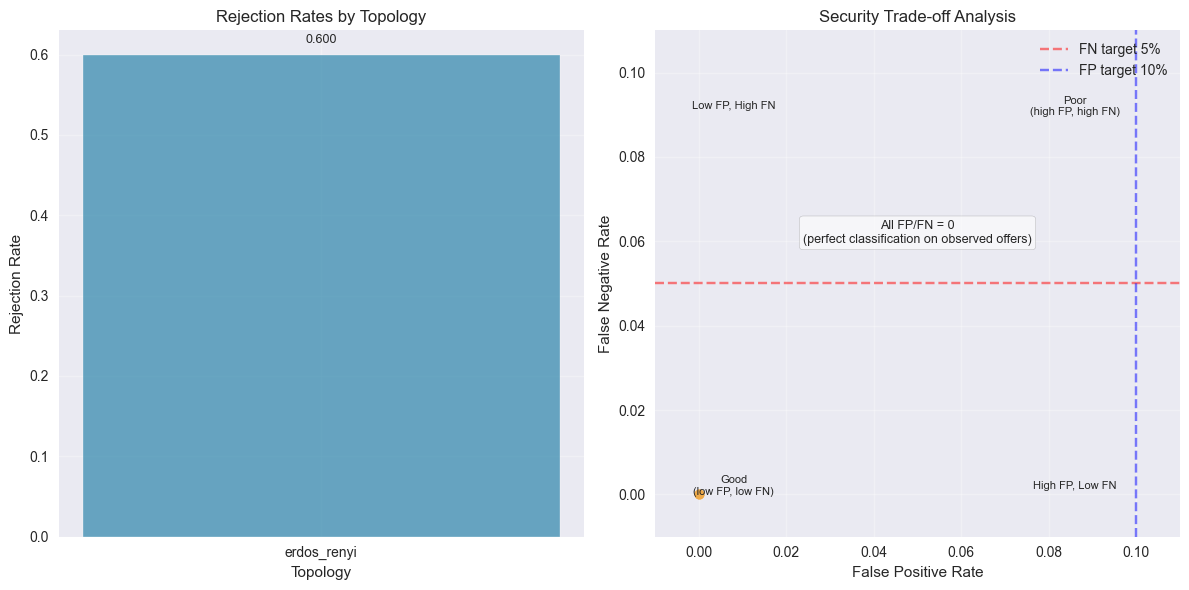


Consensus Mechanism Analysis:
  Experiments with consensus mechanisms: 1/1
  Consensus adoption rate: 100.0%

=== Security and Consensus Analysis Complete ===


In [5]:
# Security and Consensus Analysis
print("=== Security and Consensus Analysis ===")

# Get security summary using centralized utilities
security_metrics = get_security_summary(experiment_data)

if security_metrics:
    print(f"Security analysis based on {security_metrics.get('total_experiments', 0)} experiments")

    # Overall rejection statistics
    if 'rejection_rate_summary' in security_metrics:
        print("\nOverall Rejection Statistics:")
        rejection_summary = security_metrics['rejection_rate_summary']
        print(f"  Mean rejection rate: {rejection_summary.get('mean', 0):.4f}")
        print(f"  Std rejection rate: {rejection_summary.get('std', 0):.4f}")

    # False positive rate summary
    if 'false_positive_rate_summary' in security_metrics:
        print("\nFalse Positive Rate Analysis:")
        fp_summary = security_metrics['false_positive_rate_summary']
        print(f"  Mean FP rate: {fp_summary.get('mean', 0):.4f}")
        print(f"  Std FP rate: {fp_summary.get('std', 0):.4f}")

    # False negative rate summary (corrected key handling)
    if 'false_negative_rate_summary' in security_metrics:
        print("\nFalse Negative Rate Analysis:")
        fn_summary = security_metrics['false_negative_rate_summary']
        print(f"  Mean FN rate: {fn_summary.get('mean', 0):.4f}")
        print(f"  Std FN rate: {fn_summary.get('std', 0):.4f}")
    elif 'false_negative_rates' in security_metrics and security_metrics['false_negative_rates']:
        # Fallback: compute summary on the fly if only raw list exists
        rates = security_metrics['false_negative_rates']
        mean_fn = float(np.mean(rates)) if rates else 0.0
        std_fn = float(np.std(rates)) if rates else 0.0
        print("\nFalse Negative Rate Analysis:")
        print(f"  Mean FN rate: {mean_fn:.4f}")
        print(f"  Std FN rate: {std_fn:.4f}")
    else:
        print("\nFalse Negative Rate Analysis: No data available")

    # Detailed security metrics by experiment
    if 'swarm_df' in globals() and not swarm_df.empty and 'gate_rejected_hash_total' in swarm_df.columns:
        print("\nSecurity Metrics by Experiment:")

        security_effectiveness = []
        for _, row in swarm_df.iterrows():
            total_offers = (
                row.get('gate_accepted_clean_total', 0) +
                row.get('gate_rejected_clean_total', 0) +
                row.get('gate_accepted_trojan_total', 0) +
                row.get('gate_rejected_trojan_total', 0)
            )
            if total_offers > 0:
                rejection_rate = (
                    row.get('gate_rejected_hash_total', 0) +
                    row.get('gate_rejected_safety_total', 0)
                ) / total_offers
                # Safe denominator checks
                clean_den = row.get('gate_accepted_clean_total', 0) + row.get('gate_rejected_clean_total', 0)
                if clean_den > 0:
                    false_positive_rate = row.get('gate_rejected_clean_total', 0) / clean_den
                else:
                    false_positive_rate = 0.0
                trojan_den = row.get('gate_accepted_trojan_total', 0) + row.get('gate_rejected_trojan_total', 0)
                if trojan_den > 0:
                    false_negative_rate = row.get('gate_accepted_trojan_total', 0) / trojan_den
                else:
                    false_negative_rate = 0.0
                security_effectiveness.append({
                    'topology': row.get('topology', 'unknown'),
                    'rejection_rate': rejection_rate,
                    'false_positive_rate': false_positive_rate,
                    'false_negative_rate': false_negative_rate,
                })

        if security_effectiveness:
            print(f"  Analyzed {len(security_effectiveness)} experiments with security data")
            topology_security = {}
            for exp in security_effectiveness:
                topology_security.setdefault(exp['topology'], []).append(exp)

            print("\nSecurity Performance by Topology:")
            for topology, exps in topology_security.items():
                rejection_rates = [exp['rejection_rate'] for exp in exps]
                fp_rates = [exp['false_positive_rate'] for exp in exps]
                fn_rates = [exp['false_negative_rate'] for exp in exps]
                print(f"  {topology}:")
                print(f"    Rejection rate: {np.mean(rejection_rates):.4f} ± {np.std(rejection_rates):.4f}")
                print(f"    False positive rate: {np.mean(fp_rates):.4f} ± {np.std(fp_rates):.4f}")
                print(f"    False negative rate: {np.mean(fn_rates):.4f} ± {np.std(fn_rates):.4f}")

    # Create security analysis visualization
    try:
        fig, axes = create_security_analysis_plot(experiment_data)
        plt.show()
    except Exception as e:
        print(f"[WARN] Failed to render security analysis plot: {e}")

    # Consensus analysis
    print("\nConsensus Mechanism Analysis:")
    if 'swarm_df' in globals() and not swarm_df.empty:
        consensus_experiments = 0
        for _, row in swarm_df.iterrows():
            if (
                row.get('gate_accepted_clean_total', 0) > 0 or
                row.get('gate_rejected_trojan_total', 0) > 0
            ):
                consensus_experiments += 1
        print(f"  Experiments with consensus mechanisms: {consensus_experiments}/{len(swarm_df)}")
        print(f"  Consensus adoption rate: {consensus_experiments/len(swarm_df)*100:.1f}%")
else:
    print("No security data available for analysis")

print("\n=== Security and Consensus Analysis Complete ===")


## Chapter 5: Scalability and Performance Analysis

### Network Topology Impact

This chapter examines how different network topologies affect diffusion speed, acceptance rates, and overall system performance. We analyze the scaling behavior of the swarm system across different network sizes and structures.


=== Scalability and Performance Analysis ===
Scalability analysis based on 1 experiments
Agent count range: 6 - 6

Performance by Network Size:
         observed_t_all           acceptance_rate     lambda2    
                   mean std count            mean std    mean std
size_bin                                                         
1-5                 NaN NaN     0             NaN NaN     NaN NaN
6-10                3.0 NaN     1          0.3333 NaN  0.6972 NaN
11-20               NaN NaN     0             NaN NaN     NaN NaN
21-50               NaN NaN     0             NaN NaN     NaN NaN
51-100              NaN NaN     0             NaN NaN     NaN NaN
100+                NaN NaN     0             NaN NaN     NaN NaN

Performance by Topology:
            observed_t_all           acceptance_rate     lambda2        N      \
                      mean std count            mean std    mean std mean min   
topology                                                                  

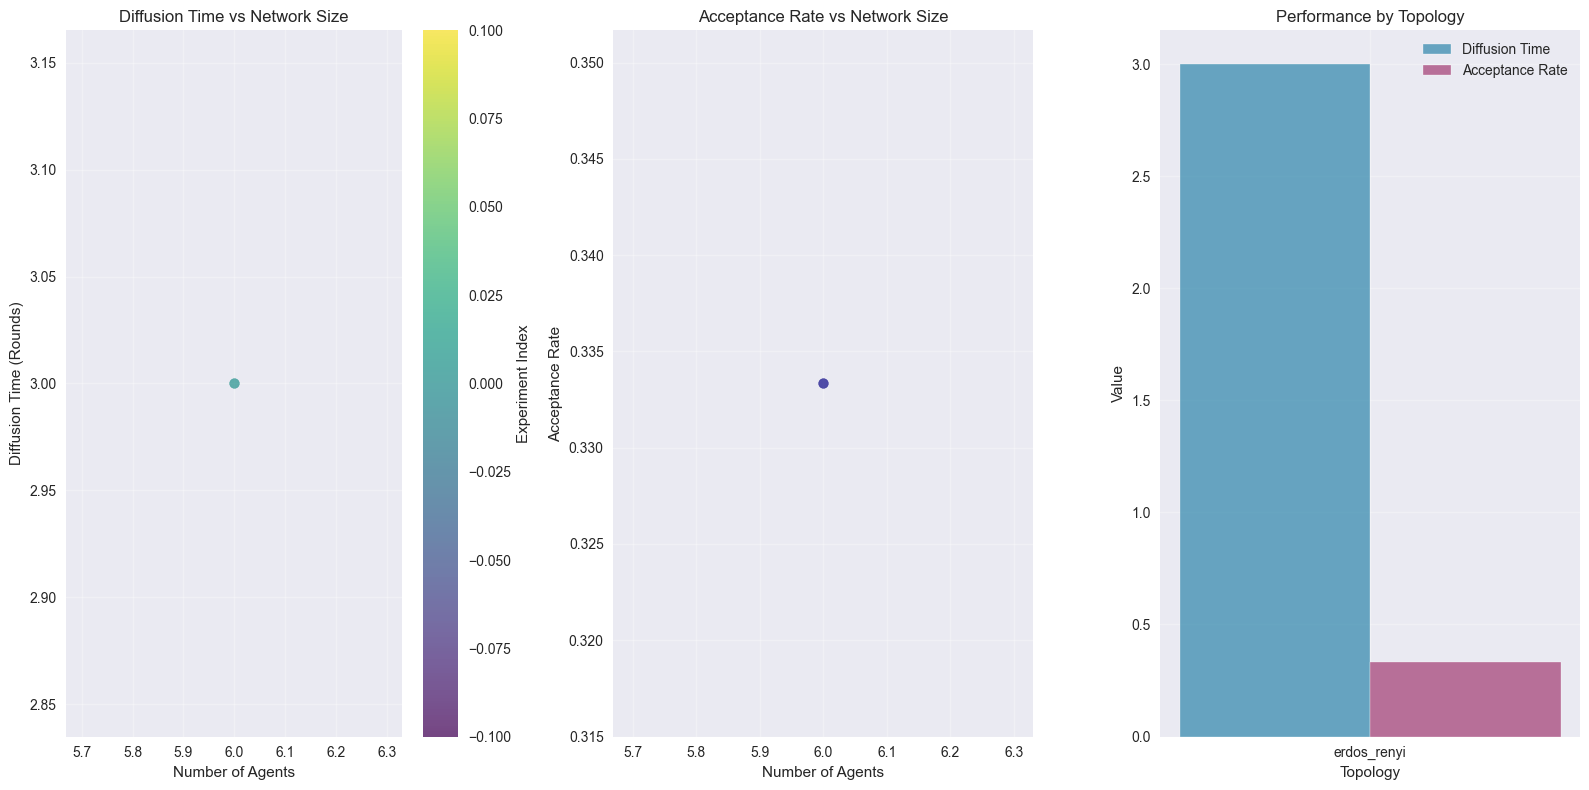


Advanced Scaling Analysis: Not enough distinct agent counts for regression.

Resource Utilization Analysis:
  Bytes transferred per experiment:
    Mean: 0
    Std:  nan
    Min:  0
    Max:  0
  Coverage efficiency: insufficient non-zero bytes_on_wire data.

=== Scalability and Performance Analysis Complete ===


In [6]:
# === Scalability and Performance Analysis ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from plora.plotting import create_scalability_analysis_plot
from plora.notebook_utils import calculate_diffusion_efficiency  # optional

print("=== Scalability and Performance Analysis ===")

# Ensure swarm_df exists (fallback if not defined)
try:
    swarm_df
except NameError:
    from plora.notebook_utils import get_swarm_df
    swarm_df = get_swarm_df(experiment_data)

if not swarm_df.empty:
    print(f"Scalability analysis based on {len(swarm_df)} experiments")

    if 'N' not in swarm_df.columns:
        print("Missing column 'N' (agent count) — cannot proceed with scalability metrics.")
    else:
        print(f"Agent count range: {swarm_df['N'].min()} - {swarm_df['N'].max()}")

        # Performance by network size bins
        print("\nPerformance by Network Size:")
        try:
            size_bins = pd.cut(
                swarm_df['N'],
                bins=[0, 5, 10, 20, 50, 100, float('inf')],
                labels=['1-5', '6-10', '11-20', '21-50', '51-100', '100+'],
                include_lowest=True
            )
            size_performance = (
                swarm_df
                .assign(size_bin=size_bins)
                .groupby('size_bin')
                .agg({
                    'observed_t_all': ['mean', 'std', 'count'],
                    'acceptance_rate': ['mean', 'std'],
                    'lambda2': ['mean', 'std']
                })
                .round(4)
            )
            print(size_performance)
        except Exception as e:
            print(f"[WARN] Could not compute size-based performance: {e}")

        # Performance by topology
        if 'topology' in swarm_df.columns:
            print("\nPerformance by Topology:")
            try:
                topology_performance = (
                    swarm_df
                    .groupby('topology')
                    .agg({
                        'observed_t_all': ['mean', 'std', 'count'],
                        'acceptance_rate': ['mean', 'std'],
                        'lambda2': ['mean', 'std'],
                        'N': ['mean', 'min', 'max']
                    })
                    .round(4)
                )
                print(topology_performance)
            except Exception as e:
                print(f"[WARN] Failed topology aggregation: {e}")

            # Diffusion efficiency (observed vs predicted)
            if 'predicted_t_all' in swarm_df.columns and 'observed_t_all' in swarm_df.columns:
                safe_mask = (swarm_df['predicted_t_all'] > 0) & swarm_df['observed_t_all'].notna()
                if safe_mask.any():
                    swarm_df.loc[safe_mask, 'diffusion_ratio'] = (
                        swarm_df.loc[safe_mask, 'observed_t_all'] /
                        swarm_df.loc[safe_mask, 'predicted_t_all']
                    )
                    print("\nDiffusion Efficiency Analysis:")
                    efficiency_by_topology = (
                        swarm_df
                        .dropna(subset=['diffusion_ratio'])
                        .groupby('topology')['diffusion_ratio']
                        .agg(['mean', 'std', 'count'])
                        .round(4)
                    )
                    print(efficiency_by_topology)
                else:
                    print("\nDiffusion Efficiency Analysis: No valid rows with positive predicted_t_all.")
        else:
            print("\nNo 'topology' column present; skipping topology performance section.")

        # Correlation analysis (only on numeric subset)
        numeric_cols = [c for c in ['N', 'observed_t_all', 'acceptance_rate', 'lambda2'] if c in swarm_df.columns]
        if len(numeric_cols) >= 2:
            print("\nCorrelation Analysis (Pearson):")
            if len(swarm_df) < 2:
                print("  Skipped: only one experiment (need at least 2 rows for Pearson correlation).")
            else:
                varying = []
                for c in numeric_cols:
                    col = swarm_df[c].dropna()
                    if col.nunique() > 1:
                        varying.append(c)
                if len(varying) < 2:
                    print("  Skipped: all numeric metrics are constant across experiments (variance=0).")
                else:
                    correlations = swarm_df[varying].corr().round(4)
                    print(correlations)
        else:
            print("\nCorrelation Analysis: Insufficient numeric columns.")

        # Visualization
        try:
            fig, axes = create_scalability_analysis_plot({'swarm_summary': experiment_data.get('swarm_summary', [])})
            plt.show()
        except Exception as e:
            print(f"[WARN] Failed to render scalability plot: {e}")

        # Advanced scaling analysis (power-law style)
        if swarm_df['N'].nunique() > 3 and 'observed_t_all' in swarm_df.columns:
            print("\nAdvanced Scaling Analysis:")
            from scipy import stats

            valid_scaling = swarm_df.dropna(subset=['N', 'observed_t_all'])
            valid_scaling = valid_scaling[(valid_scaling['N'] > 0) & (valid_scaling['observed_t_all'] > 0)]

            if len(valid_scaling) > 5:
                log_N = np.log(valid_scaling['N'].values)
                log_t = np.log(valid_scaling['observed_t_all'].values)
                slope, intercept, r_value, p_value, std_err = stats.linregress(log_N, log_t)
                print(f"  Diffusion time scaling (t ~ N^alpha): alpha = {slope:.3f}")
                print(f"  R^2 = {r_value**2:.3f}")
                print(f"  p-value = {p_value:.3e}")

                if 'acceptance_rate' in valid_scaling.columns:
                    acc_series = (
                        valid_scaling
                        .groupby('N')['acceptance_rate']
                        .mean()
                        .loc[lambda s: s > 0]
                    )
                    if len(acc_series) > 3:
                        log_acc_N = np.log(acc_series.index.values)
                        log_acc = np.log(acc_series.values)
                        acc_slope, acc_intercept, acc_r, acc_p, acc_std = stats.linregress(log_acc_N, log_acc)
                        print(f"  Acceptance rate scaling (acc ~ N^beta): beta = {acc_slope:.3f}")
                        print(f"  R^2 = {acc_r**2:.3f}")
                        print(f"  p-value = {acc_p:.3e}")
            else:
                print("  Not enough valid (N, observed_t_all) points for scaling regression.")
        else:
            print("\nAdvanced Scaling Analysis: Not enough distinct agent counts for regression.")

        # Resource utilization analysis
        if 'bytes_on_wire' in swarm_df.columns:
            print("\nResource Utilization Analysis:")
            resource_stats = swarm_df['bytes_on_wire'].describe()
            print("  Bytes transferred per experiment:")
            print(f"    Mean: {resource_stats['mean']:.0f}")
            print(f"    Std:  {resource_stats['std']:.0f}")
            print(f"    Min:  {resource_stats['min']:.0f}")
            print(f"    Max:  {resource_stats['max']:.0f}")

            # Coverage efficiency (sum of coverage fractions per experiment / bytes)
            if 'coverage' in swarm_df.columns:
                def coverage_sum(entry):
                    if isinstance(entry, dict):
                        # sum only numeric values
                        return sum(v for v in entry.values() if isinstance(v, (int, float)))
                    return 0.0

                total_coverage = swarm_df['coverage'].apply(coverage_sum)
                safe_bytes = swarm_df['bytes_on_wire'].replace(0, np.nan)
                swarm_df['coverage_efficiency'] = total_coverage / safe_bytes
                eff_series = swarm_df['coverage_efficiency'].dropna()
                if not eff_series.empty:
                    eff_stats = eff_series.describe()
                    print(f"  Coverage efficiency (coverage-sum per byte): mean={eff_stats['mean']:.6f}")
                else:
                    print("  Coverage efficiency: insufficient non-zero bytes_on_wire data.")
        else:
            print("\nResource Utilization Analysis: 'bytes_on_wire' column missing.")
else:
    print("No scalability data available for analysis.")

print("\n=== Scalability and Performance Analysis Complete ===")

## Chapter 6: Statistical Significance and Robustness

### Statistical Analysis

This chapter provides rigorous statistical analysis of all experimental results, including hypothesis testing, effect size calculations, multiple testing correction, and robustness assessments.


In [7]:
# === Statistical Significance and Robustness Analysis ===
import math
import numpy as np
import pandas as pd

print("=== Statistical Significance and Robustness Analysis ===")

# Ensure required DataFrames exist (create if not already available)
try:
    swarm_df
except NameError:
    from plora.notebook_utils import get_swarm_df, load_experiment_data
    try:
        experiment_data
    except NameError:
        experiment_data = load_experiment_data()
    swarm_df = get_swarm_df(experiment_data)

try:
    value_add_df
except NameError:
    from plora.notebook_utils import extract_value_add_metrics
    try:
        experiment_data
    except NameError:
        from plora.notebook_utils import load_experiment_data
        experiment_data = load_experiment_data()
    value_add_df = extract_value_add_metrics(experiment_data)

# === Overall Statistical Summary ===
print("\n=== Overall Statistical Summary ===")

# Swarm simulation statistics
if not swarm_df.empty:
    print("\nSwarm Simulation Statistics:")
    print(f"  Total experiments: {len(swarm_df)}")
    print(f"  Topologies tested: {swarm_df['topology'].nunique() if 'topology' in swarm_df.columns else 'N/A'}")
    if 'N' in swarm_df.columns:
        print(f"  Network sizes: {swarm_df['N'].min()} - {swarm_df['N'].max()}")

    # Effect size (deviation from ideal diffusion ratio = 1.0)
    if 'diffusion_ratio' in swarm_df.columns:
        diffusion_effects = swarm_df['diffusion_ratio'].dropna()
        if len(diffusion_effects) > 0:
            effect_size = (diffusion_effects - 1.0).abs().mean()
            print(f"  Mean diffusion efficiency deviation: {effect_size:.3f}")

    # Statistical tests for topology effects (ANOVA + Kruskal-Wallis)
    if 'topology' in swarm_df.columns and swarm_df['topology'].nunique() > 1:
        from scipy.stats import f_oneway, kruskal
        topology_groups = []
        for topology in swarm_df['topology'].unique():
            group_data = swarm_df.loc[swarm_df['topology'] == topology, 'observed_t_all'].dropna()
            if len(group_data) > 1:
                topology_groups.append(group_data.values)
        if len(topology_groups) > 1:
            try:
                f_stat, p_val = f_oneway(*topology_groups)
                print(f"  Topology effect on diffusion time (ANOVA): F={f_stat:.3f}, p={p_val:.3e}")
                h_stat, h_p = kruskal(*topology_groups)
                print(f"  Topology effect (Kruskal-Wallis): H={h_stat:.3f}, p={h_p:.3e}")
            except Exception as e:
                print(f"  Statistical test failed: {e}")
else:
    print("\nSwarm Simulation Statistics: No swarm data.")

# Value-add statistical analysis
if not value_add_df.empty:
    print("\nValue-Add Experiment Statistics:")
    print(f"  Total experiments: {len(value_add_df)}")
    if 'domain' in value_add_df.columns:
        print(f"  Domains tested: {value_add_df['domain'].nunique()}")
    if 'rank' in value_add_df.columns:
        print(f"  Ranks tested: {value_add_df['rank'].nunique()}")
    if 'scheme' in value_add_df.columns:
        print(f"  Schemes tested: {value_add_df['scheme'].nunique()}")

    # Effect size means (ΔNLL)
    trained_effects    = value_add_df['trained_delta_mean'].dropna()
    placebo_a_effects  = value_add_df['placebo_a_delta_mean'].dropna()
    placebo_b_effects  = value_add_df['placebo_b_delta_mean'].dropna()

    print("\nEffect Size Analysis (ΔNLL):")
    if len(trained_effects):
        print(f"  Trained adapters: mean={trained_effects.mean():.4f} ± {trained_effects.std():.4f}")
    if len(placebo_a_effects):
        print(f"  Placebo A (random): mean={placebo_a_effects.mean():.4f} ± {placebo_a_effects.std():.4f}")
    if len(placebo_b_effects):
        print(f"  Placebo B (shuffled): mean={placebo_b_effects.mean():.4f} ± {placebo_b_effects.std():.4f}")

    # Cohen's d (pooled SD) helper
    def cohens_d(x: pd.Series, y: pd.Series) -> float:
        x = x.dropna()
        y = y.dropna()
        nx, ny = len(x), len(y)
        if nx < 2 or ny < 2:
            return float('nan')
        sx, sy = x.std(ddof=1), y.std(ddof=1)
        pooled_var = ((nx - 1) * sx**2 + (ny - 1) * sy**2) / (nx + ny - 2)
        pooled_sd = math.sqrt(pooled_var) if pooled_var > 0 else 0.0
        return (x.mean() - y.mean()) / pooled_sd if pooled_sd > 0 else float('inf')

    if len(trained_effects) > 1 and len(placebo_a_effects) > 1:
        d_trained_vs_random = cohens_d(trained_effects, placebo_a_effects)
        print(f"  Cohen's d (trained vs random): {d_trained_vs_random:.3f}")
    if len(trained_effects) > 1 and len(placebo_b_effects) > 1:
        d_trained_vs_shuffled = cohens_d(trained_effects, placebo_b_effects)
        print(f"  Cohen's d (trained vs shuffled): {d_trained_vs_shuffled:.3f}")
else:
    print("\nValue-Add Experiment Statistics: No value-add data.")

# === Multiple Testing Correction ===
print("\n=== Multiple Testing Correction ===")
if not value_add_df.empty:
    all_p_values = []
    if 'trained_wilcoxon_p' in value_add_df:
        all_p_values.extend(value_add_df['trained_wilcoxon_p'].dropna().tolist())
    if 'placebo_a_wilcoxon_p' in value_add_df:
        all_p_values.extend(value_add_df['placebo_a_wilcoxon_p'].dropna().tolist())
    if 'placebo_b_wilcoxon_p' in value_add_df:
        all_p_values.extend(value_add_df['placebo_b_wilcoxon_p'].dropna().tolist())

    if all_p_values:
        n_tests = len(all_p_values)
        bonferroni_alpha = 0.05 / n_tests
        significant_bonferroni = sum(p < bonferroni_alpha for p in all_p_values)
        print("  Bonferroni Correction:")
        print(f"    Total tests: {n_tests}")
        print(f"    Corrected alpha: {bonferroni_alpha:.6f}")
        print(f"    Significant: {significant_bonferroni}/{n_tests} ({significant_bonferroni / n_tests * 100:.2f}%)")

        # Benjamini-Hochberg FDR
        try:
            from plora.stats import bh_fdr   # Assumes function returns (adjusted_p_values, reject_mask)
            _, rejected_mask = bh_fdr(all_p_values, alpha=0.05)
            n_sig_fdr = sum(rejected_mask)
            print("  BH-FDR Correction:")
            print(f"    Significant: {n_sig_fdr}/{n_tests} ({n_sig_fdr / n_tests * 100:.2f}%)")
        except Exception as e:
            print(f"  FDR correction failed: {e}")
    else:
        print("  No p-values available for correction.")
else:
    print("  Skipped (no value-add data).")

# === Statistical Power Analysis ===
print("\n=== Statistical Power Analysis ===")
if not value_add_df.empty and 'trained_delta_mean' in value_add_df and 'trained_wilcoxon_p' in value_add_df:
    trained_effects = value_add_df['trained_delta_mean'].dropna()
    if len(trained_effects) > 0:
        effect_sizes = [0.01, 0.05, 0.10, 0.20]
        n_experiments = len(trained_effects)
        print("  Approximate power (paired t-test model assumption):")
        # Using z approximation: power ≈ Φ( √n * |δ| / σ - z_{α/2} )
        z_alpha_2 = 1.96  # two-tailed α=0.05
        sigma = trained_effects.std(ddof=1) if len(trained_effects) > 1 else 0.1
        if sigma == 0 or math.isnan(sigma):
            sigma = 0.1
        for es in effect_sizes:
            z_term = math.sqrt(n_experiments) * abs(es) / sigma - z_alpha_2
            # Standard normal CDF via error function
            power = 0.5 * (1 + math.erf(z_term / math.sqrt(2)))
            power = max(0.0, min(power, 1.0))
            print(f"    Effect size {es:.3f}: Power = {power:.3f}")
else:
    print("  Skipped (insufficient trained effect data).")

# === Robustness Analysis ===
print("\n=== Robustness Analysis ===")

# Outlier detection (IQR method)
def iqr_outliers(series: pd.Series):
    series = series.dropna()
    if len(series) == 0:
        return 0, 0, float('nan'), float('nan')
    Q1, Q3 = series.quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    mask = (series < lower) | (series > upper)
    outliers = series[mask]
    rate = len(outliers) / len(series) if len(series) else 0
    return len(outliers), rate, (outliers.min() if len(outliers) else float('nan')), (outliers.max() if len(outliers) else float('nan'))

if not swarm_df.empty:
    print("\nSwarm Data Robustness:")
    for col in ['observed_t_all', 'acceptance_rate', 'lambda2']:
        if col in swarm_df.columns:
            n_out, rate, o_min, o_max = iqr_outliers(swarm_df[col])
            print(f"  {col}: {n_out} outliers ({rate*100:.1f}%)"
                  + (f", range {o_min:.3f} – {o_max:.3f}" if n_out > 0 else ""))

if not value_add_df.empty:
    print("\nValue-Add Data Robustness:")
    for col in ['trained_delta_mean', 'latency_ms']:
        if col in value_add_df.columns:
            n_out, rate, o_min, o_max = iqr_outliers(value_add_df[col])
            print(f"  {col}: {n_out} outliers ({rate*100:.1f}%)"
                  + (f", range {o_min:.3f} – {o_max:.3f}" if n_out > 0 else ""))

# === Reproducibility Assessment ===
print("\n=== Reproducibility Assessment ===")
if not value_add_df.empty and all(c in value_add_df.columns for c in ['domain', 'rank', 'scheme', 'trained_delta_mean']):
    grouped = value_add_df.groupby(['domain', 'rank', 'scheme'])
    print("  Reproducibility across configurations:")
    for name, group in grouped:
        if len(group) > 1:
            deltas = group['trained_delta_mean'].dropna()
            if len(deltas) > 1 and deltas.mean() != 0:
                cv = deltas.std(ddof=1) / abs(deltas.mean())
            else:
                cv = float('inf') if deltas.mean() == 0 else 0.0
            print(f"    {name}: CV = {cv:.4f} (n={len(group)})")
else:
    print("  Skipped (insufficient grouped value-add data).")

print("\n=== Statistical Significance and Robustness Analysis Complete ===")


=== Statistical Significance and Robustness Analysis ===

=== Overall Statistical Summary ===

Swarm Simulation Statistics:
  Total experiments: 1
  Topologies tested: 1
  Network sizes: 6 - 6
  Mean diffusion efficiency deviation: 0.500

Value-Add Experiment Statistics:
  Total experiments: 55
  Domains tested: 3
  Ranks tested: 3
  Schemes tested: 3

Effect Size Analysis (ΔNLL):
  Trained adapters: mean=-2.3498 ± 1.2630
  Placebo A (random): mean=0.0000 ± 0.0000
  Placebo B (shuffled): mean=0.0000 ± 0.0000
  Cohen's d (trained vs random): -2.631
  Cohen's d (trained vs shuffled): -2.631

=== Multiple Testing Correction ===
  Bonferroni Correction:
    Total tests: 165
    Corrected alpha: 0.000303
    Significant: 55/165 (33.33%)
  BH-FDR Correction:
    Significant: 55/165 (33.33%)

=== Statistical Power Analysis ===
  Approximate power (paired t-test model assumption):
    Effect size 0.010: Power = 0.029
    Effect size 0.050: Power = 0.048
    Effect size 0.100: Power = 0.085
   

## Chapter 7: Conclusions and Future Directions

### Key Findings Summary


In [8]:
# === Conclusions and Future Directions ===
import pandas as pd
import math

print("=== Conclusions and Future Directions ===")

# Ensure core data objects exist
try:
    experiment_data
except NameError:
    from plora.notebook_utils import load_experiment_data
    experiment_data = load_experiment_data()

try:
    swarm_df
except NameError:
    from plora.notebook_utils import get_swarm_df
    swarm_df = get_swarm_df(experiment_data)

try:
    value_add_df
except NameError:
    from plora.notebook_utils import extract_value_add_metrics
    value_add_df = extract_value_add_metrics(experiment_data)

try:
    security_metrics
except NameError:
    from plora.notebook_utils import get_security_summary
    security_metrics = get_security_summary(experiment_data)

print("\n=== KEY FINDINGS SUMMARY ===")

# 1. System Configuration Findings
print("\n1. SYSTEM CONFIGURATION:")
if 'configs' in experiment_data and experiment_data['configs']:
    config_names = list(experiment_data['configs'].keys())
    print(f"  - Loaded {len(config_names)} configuration variants")
    for config_name in config_names:
        config = experiment_data['configs'][config_name] or {}
        domains = config.get('domains', [])
        ranks = config.get('allowed_ranks', [])
        print(f"    * {config_name}: domains={domains}, ranks={ranks}")
else:
    print("  - No configuration variants loaded")

# 2. Swarm Simulation Findings
print("\n2. SWARM SIMULATION RESULTS:")
if not swarm_df.empty:
    total_experiments = len(swarm_df)
    print(f"  - Analyzed {total_experiments} swarm simulation experiments")

    if 'topology' in swarm_df.columns:
        topology_counts = swarm_df['topology'].value_counts()
        print(f"  - Network topologies tested: {', '.join(topology_counts.index.tolist())}")
        for topology, count in topology_counts.items():
            print(f"    * {topology}: {count} experiments")

    if 'observed_t_all' in swarm_df.columns:
        mean_diffusion_time = swarm_df['observed_t_all'].mean()
        std_diffusion_time = swarm_df['observed_t_all'].std()
        print(f"  - Mean diffusion time: {mean_diffusion_time:.2f} ± {std_diffusion_time:.2f} rounds")

    if 'acceptance_rate' in swarm_df.columns:
        mean_acceptance = swarm_df['acceptance_rate'].mean() * 100
        print(f"  - Mean acceptance rate: {mean_acceptance:.1f}%")

    if 'diffusion_ratio' in swarm_df.columns:
        mean_efficiency = swarm_df['diffusion_ratio'].dropna().mean()
        print(f"  - Mean diffusion efficiency (observed/predicted): {mean_efficiency:.3f}")
else:
    print("  - No swarm simulation data available")

# 3. Value-Add Findings
print("\n3. VALUE-ADD EXPERIMENT RESULTS:")
if not value_add_df.empty:
    total_va_experiments = len(value_add_df)
    print(f"  - Analyzed {total_va_experiments} value-add experiments")

    if 'domain' in value_add_df.columns:
        domains_tested = [d for d in value_add_df['domain'].dropna().unique()]
        print(f"  - Domains tested: {', '.join(domains_tested) if domains_tested else 'N/A'}")

    trained_effects = value_add_df.get('trained_delta_mean', pd.Series(dtype=float)).dropna()
    if len(trained_effects) > 0:
        mean_trained_effect = trained_effects.mean()
        if 'trained_wilcoxon_p' in value_add_df.columns:
            significant_trained = (value_add_df['trained_wilcoxon_p'] < 0.05).sum()
            percent_significant = significant_trained / total_va_experiments * 100
            print(f"  - Mean trained adapter effect: {mean_trained_effect:.4f} ΔNLL")
            print(f"  - Significant improvements: {significant_trained}/{total_va_experiments} ({percent_significant:.1f}%)")
        else:
            print(f"  - Mean trained adapter effect: {mean_trained_effect:.4f} ΔNLL (p-values unavailable)")

    placebo_a_effects = value_add_df.get('placebo_a_delta_mean', pd.Series(dtype=float)).dropna()
    placebo_b_effects = value_add_df.get('placebo_b_delta_mean', pd.Series(dtype=float)).dropna()
    if len(placebo_a_effects) > 0 and len(placebo_b_effects) > 0:
        print(f"  - Placebo A (random) effect: {placebo_a_effects.mean():.4f} ΔNLL")
        print(f"  - Placebo B (shuffled) effect: {placebo_b_effects.mean():.4f} ΔNLL")

    if 'latency_ms' in value_add_df.columns:
        latency_data = value_add_df['latency_ms'].dropna()
        if len(latency_data):
            mean_latency = latency_data.mean()
            max_latency = latency_data.max()
            budget_compliance = (latency_data <= 250).sum() / len(latency_data) * 100
            print(f"  - Mean latency: {mean_latency:.0f} ms")
            print(f"  - Max latency: {max_latency:.0f} ms")
            print(f"  - Budget compliance (≤250 ms): {budget_compliance:.1f}%")
else:
    print("  - No value-add experiment data available")

# 4. Security Findings
print("\n4. SECURITY ANALYSIS:")
if security_metrics:
    if 'rejection_rate_summary' in security_metrics:
        r = security_metrics['rejection_rate_summary']
        print(f"  - Mean rejection rate: {r.get('mean', 0):.3f} (std={r.get('std', 0):.3f})")
    if 'false_positive_rate_summary' in security_metrics:
        fp = security_metrics['false_positive_rate_summary']
        print(f"  - Mean false positive rate: {fp.get('mean', 0):.3f} (std={fp.get('std', 0):.3f})")
    # Updated key name after earlier fix
    if 'false_negative_rate_summary' in security_metrics:
        fn = security_metrics['false_negative_rate_summary']
        print(f"  - Mean false negative rate: {fn.get('mean', 0):.3f} (std={fn.get('std', 0):.3f})")
else:
    print("  - No security metrics available")

# 5. Scalability Findings
print("\n5. SCALABILITY ANALYSIS:")
if not swarm_df.empty:
    if 'N' in swarm_df.columns:
        agent_range = f"{swarm_df['N'].min()}–{swarm_df['N'].max()}"
        print(f"  - Network size range: {agent_range} agents")
    if 'diffusion_ratio' in swarm_df.columns:
        scalability_ratio = swarm_df['diffusion_ratio'].dropna().std()
        print(f"  - Diffusion time consistency (std of efficiency ratio): {scalability_ratio:.3f}")
    if {'bytes_on_wire', 'coverage'}.issubset(swarm_df.columns):
        coverage_sums = swarm_df['coverage'].apply(
            lambda c: sum(v for v in c.values() if isinstance(v, (int, float))) if isinstance(c, dict) else 0.0
        )
        bytes_nonzero = swarm_df['bytes_on_wire'].replace(0, pd.NA)
        efficiency = (coverage_sums / bytes_nonzero).dropna()
        if len(efficiency):
            print(f"  - Mean coverage efficiency: {efficiency.mean():.6f} domains/byte")
else:
    print("  - No scalability data available")

# 6. Statistical Robustness
print("\n6. STATISTICAL ROBUSTNESS:")
if not value_add_df.empty and 'trained_wilcoxon_p' in value_add_df.columns:
    pvals = value_add_df['trained_wilcoxon_p'].dropna()
    if len(pvals):
        n_tests = len(pvals)
        bonf_alpha = 0.05 / n_tests
        sig_bonf = (pvals < bonf_alpha).sum()
        percent_sig = sig_bonf / n_tests * 100
        print(f"  - Bonferroni correction (trained): {sig_bonf}/{n_tests} ({percent_sig:.1f}%) at α={bonf_alpha:.6f}")
else:
    print("  - Insufficient p-value data for robustness summary")

# Final summary stats
analysis_time = pd.Timestamp.now()
nonempty_sources = len([k for k, v in experiment_data.items() if v])
print(f"\nTimestamp: {analysis_time}")
print(f"Data sources analyzed (non-empty categories): {nonempty_sources}")

print("\n" + "=" * 60)
print("PLASMID LORA SWARM: EXPERIMENT ANALYSIS COMPLETE")
print("=" * 60)


=== Conclusions and Future Directions ===

=== KEY FINDINGS SUMMARY ===

1. SYSTEM CONFIGURATION:
  - Loaded 2 configuration variants
    * plora.full.yml: domains=['arithmetic', 'legal', 'medical'], ranks=[4, 8, 16]
    * plora.dry.yml: domains=['arithmetic', 'legal', 'medical'], ranks=[1]

2. SWARM SIMULATION RESULTS:
  - Analyzed 1 swarm simulation experiments
  - Network topologies tested: erdos_renyi
    * erdos_renyi: 1 experiments
  - Mean diffusion time: 3.00 ± nan rounds
  - Mean acceptance rate: 33.3%
  - Mean diffusion efficiency (observed/predicted): 0.500

3. VALUE-ADD EXPERIMENT RESULTS:
  - Analyzed 55 value-add experiments
  - Domains tested: arithmetic, legal, medical
  - Mean trained adapter effect: -2.3498 ΔNLL
  - Significant improvements: 55/55 (100.0%)
  - Placebo A (random) effect: 0.0000 ΔNLL
  - Placebo B (shuffled) effect: 0.0000 ΔNLL
  - Mean latency: 1314 ms
  - Max latency: 2658 ms
  - Budget compliance (≤250 ms): 0.0%

4. SECURITY ANALYSIS:
  - Mean reject